In [1]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------LIBRARIES---------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#!pip install torch torchvision
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import VOCDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.multiprocessing as mp
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from typing import Dict
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image
import xml.etree.ElementTree as ET
import collections
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torchviz
from torchsummary import summary


#-------------------------------------------------------------------------------------JUPYTER NOTEBOOK SETTINGS-------------------------------------------------------------------------------------
from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))     

C:\Users\Ciprian-Florin Ifrim\AppData\Local\Temp\ipykernel_2784\794687123.py:42: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [9]:
# Load the pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Replace the classifier with a new one
CUSTOM_CLASSES = ['name', 'value', 'x-axis', 'y-axis', 'plot']
num_classes = len(CUSTOM_CLASSES) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Put model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load saved model
model.load_state_dict(torch.load('pytorch_rcnn_models/EXPERIMENTAL_4_rcnn_batch-16_epoch-20_full-crypto.com_non-augmented.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# THIS IS A WAY TO LOAD MODELS TRAINED USING DISTRIBUTED DATA PARALLEL BUT SAVED WITH THE REGULAR 1 GPU METHOD
# Initialize the model with the same architecture
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Replace the classifier with a new one
CUSTOM_CLASSES = ['name', 'value', 'x-axis', 'y-axis', 'plot']
num_classes = len(CUSTOM_CLASSES) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Put model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the state_dict you've saved
state_dict = torch.load('pytorch_rcnn_models/FINAL_rcnn_batch-16_epoch-60_full-enchanced-original_non-augmented.pt')

# Create a new state_dict without 'module.' prefix
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

# Load the new state_dict into the model
model.load_state_dict(new_state_dict)
model.eval()

In [ ]:
# SAVING THE MODEL AS ONNX
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# Create a custom Faster RCNN model
class CustomFasterRCNN(FasterRCNN):
    def __init__(self, num_classes):
        # Use a pre-trained ResNet50-FPN backbone
        backbone = resnet_fpn_backbone('resnet50', pretrained=False)
        super().__init__(backbone, num_classes)

        self.transform = GeneralizedRCNNTransform(
            min_size=800,
            max_size=1333,
            image_mean=[0.485, 0.456, 0.406],
            image_std=[0.229, 0.224, 0.225]
        )

    def forward(self, images):
        # Simulate the forward flow through the components
        images, _ = self.transform(images)
        features = self.backbone(images.tensors)
        proposals, proposal_losses = self.rpn(images, features, None)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, None)
        return detections

# Replace the classifier with a new one
CUSTOM_CLASSES = ['name', 'value', 'x-axis', 'y-axis', 'plot']
num_classes = len(CUSTOM_CLASSES) + 1
model = CustomFasterRCNN(num_classes)

# Put model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load saved model
model.load_state_dict(torch.load('pytorch_rcnn_models/rcnn_batch-16_epoch-20_full-crypto.com_non-augmented'))
model.eval()

dummy_input = torch.randn(1, 3, 800, 800).to(device)
torch.onnx.export(model, dummy_input, "faster_rcnn.onnx")

In [18]:
# Data processing
data_transforms = transforms.Compose([
    transforms.Resize((482*2, 369*2)),
    #transforms.Resize(512),                                            
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# Open the file
with open('pascal_voc_datasets/VOCdevkit/PlotsEnchanced_Original_With-1X-Augmentation/ImageSets/Main/experimental.txt', 'r') as file:
    # Iterate over each line
    for line in file:
        # Strip removes trailing and leading whitespace, including the newline character
        line = line.strip()

        image_path = 'pascal_voc_datasets/VOCdevkit/PlotsEnchanced_Original_With-1X-Augmentation/JPEGImages/'
        img = Image.open(image_path + line + ".jpg")
        img = data_transforms(img)
        img = img.to(device)  # This line transfers the image to the GPU if it is available

        # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
        # Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
        #img = img.unsqueeze(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.

        with torch.no_grad():
            prediction = model([img])
        
                # Check if predictions exist
        if len(prediction[0]['boxes']) > 0:
            print(line)
            print(prediction[0]['scores'])
            print(len(prediction[0]['boxes']))
            print(len(prediction[0]['labels']))

image102005_aug_0
tensor([1.0000, 1.0000, 0.9996, 0.9984, 0.0989], device='cuda:0')
5
5
image71070
tensor([1.0000, 1.0000, 1.0000, 0.9999, 0.9972, 0.9138], device='cuda:0')
6
6
image56705
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9987], device='cuda:0')
5
5
image64008
tensor([1.0000, 1.0000, 1.0000, 0.9959, 0.8244, 0.8188], device='cuda:0')
6
6
image89745_aug_0
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9104, 0.5665], device='cuda:0')
6
6
image64707
tensor([1.0000, 1.0000, 1.0000, 0.9919, 0.3423], device='cuda:0')
5
5
image35842_aug_0
tensor([1.0000, 0.9999, 0.9999, 0.9469, 0.1080], device='cuda:0')
5
5
image64939_aug_0
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9979], device='cuda:0')
5
5
image10159
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9987], device='cuda:0')
5
5
image24843
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9966, 0.2271], device='cuda:0')
6
6
image42267
tensor([1.0000, 0.9999, 0.9810, 0.9004, 0.8299, 0.5435, 0.1890],
       device='cuda:0')
7
7
image104570
tensor([1.0000, 1

KeyboardInterrupt: 

tensor([[  7.7238,  15.0088, 659.5277,  70.9848],
        [ 25.9002, 178.8814,  64.9814, 613.0656],
        [ 14.9504, 129.8289, 510.8798, 162.0425],
        [ 62.0967, 180.9140, 738.0000, 582.3038],
        [ 68.3713, 582.8641, 738.0000, 611.9595]], device='cuda:0')
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9979], device='cuda:0')


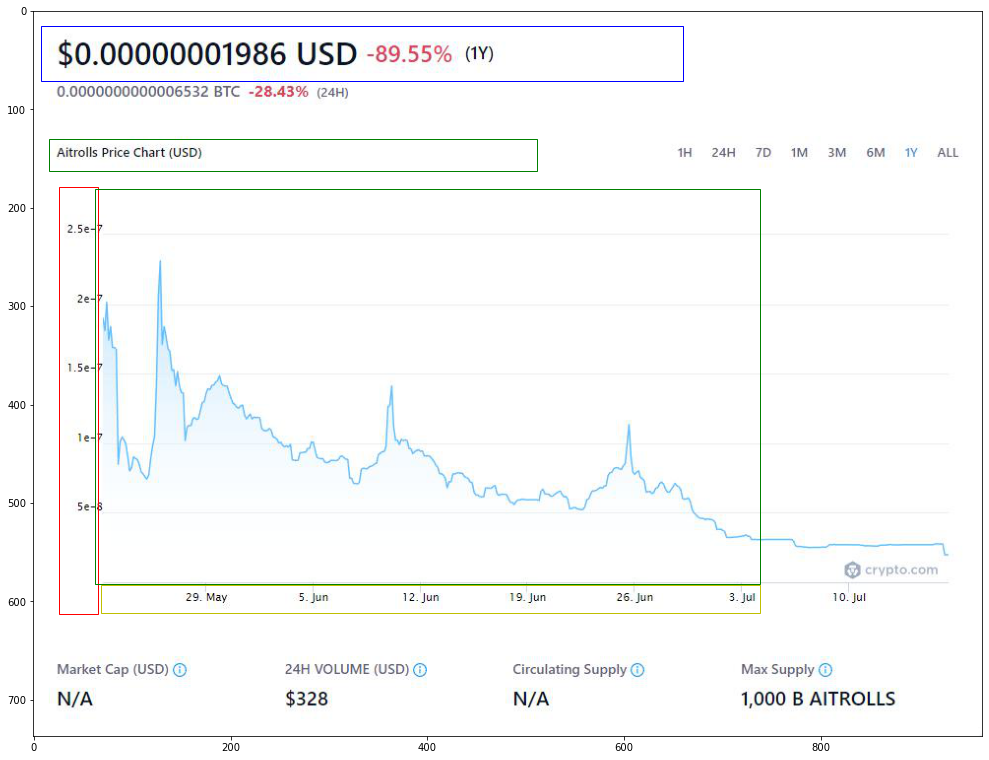

In [19]:
image_path = 'pascal_voc_datasets/VOCdevkit/PlotsEnchanced_Original_With-1X-Augmentation/JPEGImages/'
img_name = 'image78876'

img = Image.open(image_path + img_name + '.jpg')
# Store the original image dimensions
orig_width, orig_height = img.size

# Process the image
img_processed = data_transforms(img)
img_processed = img_processed.to(device)  # Transfer the image to the GPU if it is available

# Calculate the scale ratios
new_width, new_height = img_processed.shape[1], img_processed.shape[2]
width_ratio = orig_width / new_width
height_ratio = orig_height / new_height

with torch.no_grad():
    prediction = model([img_processed])

# Scale bounding boxes back to original image size
for box in prediction[0]['boxes']:
    box[0] *= width_ratio
    box[2] *= width_ratio
    box[1] *= height_ratio
    box[3] *= height_ratio

print(prediction[0]['boxes'])
print(prediction[0]['scores'])

# Draw the bounding boxes on the image
fig, ax = plt.subplots(1, figsize=(17, 15))  # Adjust the size as needed. Here, the figure size is 12x12 inches.
ax.imshow(img)

colors = ['r', 'g', 'b', 'y']

# We will draw all the boxes with a score above 0.5
for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if score > 0.9:  # Check if the score is above 0.5
        xmin, ymin, xmax, ymax = box.cpu().numpy()  # Move the box coordinates to the CPU
        rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), edgecolor=colors[label%4], facecolor='none')
        ax.add_patch(rect)

plt.show()